In [1]:
from warnings import simplefilter

import numpy as np
import pandas as pd

from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.theta import ThetaForecaster
from sktime.utils.plotting import plot_series

simplefilter("ignore", FutureWarning)
%matplotlib inline

In [46]:
'''
Open HDF5 datafile
'''
import h5py
import geopandas as gpd
import json 
jsn_grp = {}
h5file = h5py.File('./processed/newdata.h5', 'r')
brazil = gpd.read_file('./data/shapefile/BR_borders/BR_MUN_WGS84.shp')
codenames = brazil.GEOCODIGO.sort_values().values

In [47]:
indicators = list(h5file)
item = 'mean'
fh = np.arange(12) + 1 
plot= True

code = np.random.choice(codenames)
indicate = np.random.choice(indicators)
print(code,indicate)
list(h5file[indicate])
code='1100049'

3512001 spi_01


In [48]:
selection = h5file[indicate][code]
dtstr = [i+'-01 00:00:00' for i in selection]



df = pd.Series([selection[i].attrs[item] for i in selection],
                 index = pd.to_datetime(dtstr).to_period('M')
              )
# we cant deal with negative values, so shift the results up
shift = abs(df.min())



In [49]:
forecaster = ThetaForecaster(sp=12)
forecaster.fit(df+shift+1)
alpha = 0.05
y_pred, pred_ints = forecaster.predict(fh, return_pred_int=True, alpha=alpha)

y_pred -= shift+1
pred_ints["lower"] -= shift+1
pred_ints["upper"] -= shift+1

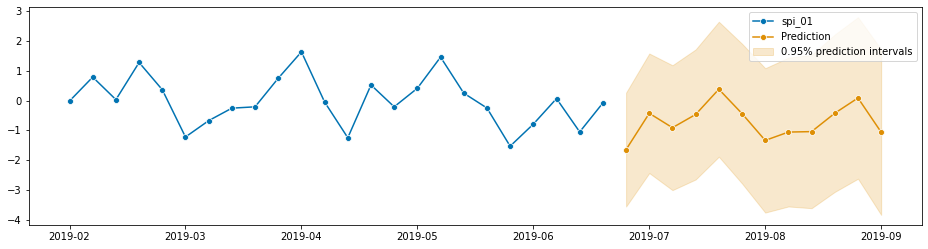

In [50]:
if plot:

    fig, ax = plot_series(df, y_pred, labels=[indicate, "Prediction"])
    ax.fill_between(
        ax.get_lines()[-1].get_xdata(),
        pred_ints["lower"],
        pred_ints["upper"],
        alpha=0.2,
        color=ax.get_lines()[-1].get_c(),
        label=f"{1 - alpha}% prediction intervals",
    )
    ax.legend();
   

In [51]:

jsn['x'] = df.index.astype('str')
jsn['y'] = df.values
jsn['px'] = y_pred.index.astype('str')
jsn['py'] = y_pred.values
jsn['pt'] = pred_ints.upper.values
jsn['pb'] = pred_ints.lower.values

for i in jsn:
    jsn[i] = list(jsn[i])

jsn_grp[indicate] = jsn
    
json.dumps(jsn_grp)



'{"spi_01": {"x": ["2019-01", "2019-02", "2019-03", "2019-04", "2019-05", "2019-06", "2019-07", "2019-08", "2019-09", "2019-10", "2019-11", "2019-12", "2020-01", "2020-02", "2020-03", "2020-04", "2020-05", "2020-06", "2020-07", "2020-08", "2020-09", "2020-10", "2020-11", "2020-12"], "y": [-0.01466515101492405, 0.7878319621086121, 0.031682103872299194, 1.277427315711975, 0.36375921964645386, -1.2211328744888306, -0.6736758947372437, -0.2544696033000946, -0.2097781002521515, 0.74904465675354, 1.6334125995635986, -0.049547456204891205, -1.2468746900558472, 0.5239159464836121, -0.20911440253257751, 0.4132685661315918, 1.4575560092926025, 0.24921026825904846, -0.249811053276062, -1.5299469232559204, -0.7899208068847656, 0.06650121510028839, -1.0509467124938965, -0.0795741081237793], "px": ["2021-01", "2021-02", "2021-03", "2021-04", "2021-05", "2021-06", "2021-07", "2021-08", "2021-09", "2021-10", "2021-11", "2021-12"], "py": [-1.644098670615584, -0.42621815324626233, -0.9095067561006625, -

In [ ]:
h5file.close()